# Tutorial #6: Applying Machine Learning Methods to Temporal Dimensions of EEG Data

In this tutorial, we will apply classification on the same EEG data as in the previous cases (link), but taking advantage of the temporal dimension of the data.

In the previous tutorials (link) we examined whether it is possible to classify EEG responses to different stimuli, at all. However, the classification was agnostic of time. It just informed that somewhere in the brain, at some point in time, there were differential EEG responses to different stimuli (to check).

Here, we go one step further, and ask the questions:
* (a) Can we classify EEG resposnes to different images?
* (b) When in time is there discriminant EEG activity?

To answer these questions, we will use the same algorithms as in the previous tutorials (link), but this time, we will train one classifier at each time instance and we will evaluate the performance of the model at each time instance in new epochs. 

The function SlidingEstimator in MNE package is provided for this purpose. This takes the model and optionally a scoring function as parameters to create a time-point by time-point classifier. After having created a sliding estimator, it can be fitted to the data, scored the estimator on each task or made predictions on new epochs.

In [1]:
# To silence the warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from mne.decoding import Vectorizer

from os.path import isfile, join
from os import listdir
import numpy as np
import statistics

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

## Analysis on temporal dimensions for each participant separately

1. Prepare data for the analysis

In [3]:
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]

#extract ids from file names
ids = [int(f[len(data_folder)+2:-4]) for f in files]



In [4]:
epochs = [mne.read_epochs(f, verbose='error') for f in files]
epochs_UN = [e['FU', 'FN'] for e in epochs]
epochs_UP = [e['FU', 'FP'] for e in epochs]
epochs_NP = [e['FN', 'FP'] for e in epochs]
# Dataset with unpleasant and neutral events
data_UN = [e.get_data() for e in epochs_UN]
labels_UN = [e.events[:,-1] for e in epochs_UN]

data_UP = [e.get_data() for e in epochs_UP]
labels_UP = [e.events[:,-1] for e in epochs_UP]

data_NP = [e.get_data() for e in epochs_NP]
labels_NP = [e.events[:,-1] for e in epochs_NP]

2. Train classifiers with sliding window estimator on data of each participant separately and apply 3-fold cross validation.

In [5]:
def applyCrossValidation(data, labels, participant_id, epochs, classifier):
    CV_score_time = None
    sl = SlidingEstimator(classifier, scoring='accuracy') 
    if np.isfinite(data).all() == True and np.isnan(data).any() == False:
        CV_score_time = cross_val_multiscore(sl, data, labels, cv=3)
        #print(sl.__estimators_)
        plotCVScores(epochs.times, CV_score_time, participant_id)
    else:
        print('Input contains NaN or infinity!')
    return CV_score_time

Following function will plot cross validation scores over time

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotCVScores(times, CV_score_time, participant_id):
    fig, ax = plt.subplots()
    fig.suptitle('CV Scores of Participant-'+str(participant_id))
    ax.plot(times, CV_score_time.T)
    plt.xlabel('Time')
    plt.ylabel('CV Accuracy')
    plt.show()

Although it is practical to use sliding estimator from mne package, it can be implemented easily. As it stated at the beginning of this tutorial, the idea behind sliding estimator is to train a model for each time point seperately and test the performance on new epochs. In following function, implementation of sliding estimator is provided.

In [7]:
def mySlidingEstimator(estimator, epochs):
    clfs = []
    for i in range(len(epochs.times)):
        clf = make_pipeline(Vectorizer(), StandardScaler(), estimator)
        clfs.append(clf)
        
    return clfs

In [20]:
import random
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle    

def applyCVtoMySlidingEstimator(clfs, epochs, data, labels, scoringMeasure='accuracy', cv_folds=3):
    data, labels = shuffle(data, labels, random_state=11)
    fold_size = int(len(data)/cv_folds)
    last_fold_size  = len(data)-fold_size*(cv_folds-1)

    cv_scores_accuracy =  np.zeros((cv_folds, len(epochs.times)))
    for i in range(cv_folds):
        start_ind  = i*fold_size
        if i < cv_folds-1: 
            end_ind = (i+1)*fold_size - 1
            current_fold_size = fold_size
        else:
            end_ind = len(epochs) - 1
            current_fold_size = last_fold_size
        print(current_fold_size)
        #data splitting
        (x,y,z) = data.shape
        test_data = np.zeros((current_fold_size, y, z))
        test_labels = np.zeros((current_fold_size, ))
        train_data = np.zeros((x-current_fold_size, y, z))
        train_labels = np.zeros((x-current_fold_size, ))
        
        test_ind, train_ind = 0, 0
        for d in range(len(data)):
            if d >= start_ind and d <= end_ind:
                test_data[test_ind,:,:] = data[d,:,:]
                test_labels[test_ind] = labels[d]
                test_ind += 1
            else:
                train_data[train_ind,:,:] = data[d,:,:]
                train_labels[train_ind] = labels[d]
        
        #apply cross validation
        for c in range(len(clfs)):
            clfs[c].fit(train_data[:,:,c], train_labels)
            preds = clfs[c].predict(test_data[:,:,c])
            acc = accuracy_score(test_labels, preds, )
            cv_scores_accuracy[i,c] = acc
        
    return cv_scores_accuracy

1
83


/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

83


/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

83


/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid val

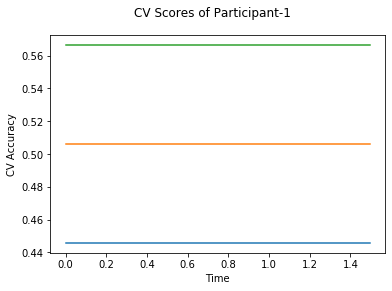

In [22]:
for i in range(1,2): #len(data_UN)
    print(i)
    clfs = mySlidingEstimator(LinearDiscriminantAnalysis(solver='svd'), epochs_UN[i])
    cv_acc_scores = applyCVtoMySlidingEstimator(clfs, epochs_UN[i], data_UN[i], labels_UN[i])
    plotCVScores(epochs_UN[i].times, cv_acc_scores, ids[i])
    #print(cv_acc_scores)
    

### Classification Between Unplesant and Neutral Events

In [ ]:
CV_score_time_UN = []
for i in range(len(data_UN)):
    clf = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    CV_score_time_UN.append(applyCrossValidation(data_UN[i], labels_UN[i], ids[i], epochs_UN[i], clf))

In [ ]:
def averageCVScores(CV_score_time):
    avg_cv_scores = []
    for cv in CV_score_time:
        avg_scores_tmp = []
        sum_col_wise = cv.sum(axis=0)
        avg_scores_tmp = [s/len(cv) for s in sum_col_wise]
        avg_cv_scores.append(avg_scores_tmp)
    return avg_cv_scores

In [ ]:
avg_cv_score_time = averageCVScores(CV_score_time_UN)
avg_cv_score_time

In [ ]:
averageCVScores(cv_acc_scores)

The following cell plots the mean and standard deviation of cross validation accuracies of participants.

In [ ]:
import pylab, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_rel, sem

def plot_conditions(data,epochs,labels):

    sns.set(style="white")
    ColorsL = np.array(([228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0]))/256
    col_axes = np.array((82, 82, 82))/256

    al = 0.2
    fig = plt.figure(num=None, figsize=(4, 2), dpi=150)

    
    epochs_mean = np.mean(data, axis = 0)
    epochs_std = sem(data, axis = 0)/2

    plt.plot(epochs[0].times, epochs_mean, color = ColorsL[0], linewidth = 2, label = labels)
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.ylabel('Mean CV Accuracy')
    plt.xlabel('Times')

Mean cross validation accuracy plot below is showing that above chance (50%) accuracy achived at each time points. 

In [ ]:
avg_cv_score_time = np.asarray(avg_cv_score_time)
plot_conditions(avg_cv_score_time,epochs_UN, labels_UN)

How do you improve the results?

Exercise: Apply filtering and also parameter optimization for LDA classifier to see the potential effects

### Group-Level Analysis on Temporal Dimension

As in the previous tutorials, participants' data are concatenated for forming the dataset required for group-level analysis.  

In [ ]:
#Load Dataset
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]
#files = files[:10]
ids = [int(f[-6:-4]) for f in files]

numberOfEpochs = np.zeros((len(ids), 3))
# Read the EEG epochs:
epochs_all_UN, epochs_all_UP, epochs_all_NP = [], [], []
for f in range(len(files)):
    epochs = mne.read_epochs(files[f], verbose='error')
    epochs_UN = epochs['FU', 'FN']
    epochs_UP = epochs['FU', 'FP']
    epochs_NP = epochs['FN', 'FP']
    numberOfEpochs[f,0] = int(len(epochs_UN.events))
    numberOfEpochs[f,1] = int(len(epochs_UP.events))
    numberOfEpochs[f,2] = int(len(epochs_NP.events))
    UN, UP, NP = [ids[f]], [ids[f]], [ids[f]]
    UN.append(epochs_UN)
    UP.append(epochs_UP)
    NP.append(epochs_NP)
    epochs_all_UN.append(UN)
    epochs_all_UP.append(UP)
    epochs_all_NP.append(NP)

epochs_all_UN = np.array(epochs_all_UN)
epochs_all_UP = np.array(epochs_all_UP)
epochs_all_NP = np.array(epochs_all_NP)

After having the dataset; data, labels and ids(participant ids) are separated by the folowing function.

In [ ]:
def getData_labels(epochs):
    data, labels, ids = [], [], []
    for p in epochs:
        tmp_epoch = p[1]
        tmp_labels = tmp_epoch.events[:,-1]
        labels.extend(tmp_labels)
        tmp_id = p[0]
        ids.extend([tmp_id]*len(tmp_labels))        
        data.extend(tmp_epoch.get_data())
        
    data = np.array(data)
    labels = np.array(labels)
    ids = np.array(ids)
    return data, labels, ids

### Task #1: Classification of Unpleasant and Pleasant Events

Before starting the model building phase, data should be checked if it contains an invalid value which can be plus/minus infinite or NaN because python's sklearn package cannot handle those values while building models. If the following cell returns "Nan or inifinite is detedted!", you need to check your dataset before moving the next step.
Note that, it may occur that the data contains no NaN or infinite value but sklearn may still give error claiming the opposite. The reason for this error is that there are some values in your dataset which have higher precision than float64 or float32 (depending your preferance while reading data at the beginning) can handle. To fix this issue you can cast your values to float64 or float32 while reading the dataset.

In [ ]:
#Preparing dataset
data_UP, labels_UP, ids_UP = getData_labels(epochs_all_UP)
if np.isfinite(data_UP).all() == True and np.isnan(data_UP).any() == False:
    print('Data does not contain nan or infinite value')
else:
    print('Nan or inifininte is detected!')

In [ ]:
clf_UP = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_UP = SlidingEstimator(clf_UP, scoring='accuracy') 
if np.isfinite(data_UP).all() == True and np.isnan(data_UP).any() == False:
    CV_score_time = cross_val_multiscore(sl_UP, data_UP, labels_UP, cv=3)
    print('Cross validation scores:\n {}'.format(CV_score_time))
else:
    print('Input contains NaN or infinity!')

In [ ]:
plotCVScores(epochs_UP.times, CV_score_time)

### Task #2: Classification of Unpleasant and Neutral Events

In [ ]:
#Preparing dataset
data_UN, labels_UN, ids_UN = getData_labels(epochs_all_UN)

Note that hyper-parameter optimization is not applied due to the computation time constraints and left as an exercise.

In [ ]:
clf_UN = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_UN = SlidingEstimator(clf_UN, scoring='accuracy') 
if np.isfinite(data_UN).all() == True and np.isnan(data_UN).any() == False:
    CV_score_time = cross_val_multiscore(sl_UN, data_UN, labels_UN, cv=3)
    print('Cross validation scores:\n {}'.format(CV_score_time))
    plotCVScores(epochs_UN.times, CV_score_time)
else:
    print('Input contains NaN or infinity!')

### Task #3: Classification of Neutral and Pleasant Events

In [ ]:
#Preparing dataset
data_NP, labels_NP, ids_NP = getData_labels(epochs_all_NP)

In [ ]:
clf_NP = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_NP = SlidingEstimator(clf_NP, scoring='accuracy') 
if np.isfinite(data_NP).all() == True and np.isnan(data_NP).any() == False:
    CV_score_time = cross_val_multiscore(sl_NP, data_NP, labels_NP, cv=3)
    print('Cross validation scores:\n {}'.format(CV_score_time))
    plotCVScores(epochs_NP.times, CV_score_time)
else:
    print('Input contains NaN or infinity!')

The above three plots show the mean cross validation accuracy over time for each classification task. The accuracies are less than 50% for all time points meaning that models do not perform above chance. In contrast to the group-level cross validation plots, the mean of cross validation scores for all participants over time is higer than 50%. So, we may conclude that high variation between participants leads to poor performance on group-level. 